# Projeto Final

Este é o projeto final da disciplina Aprendizado de Máquina (IA006-C), ministrado pelos professores Levy Boccato e Romis, na Unicamp no 2S2019.

## Projeto

A ideia do projeto é permitir a clusterização de conteúdo textual, para que a partir deste seja criado um chatbot.

Os textos passarão pro um processo de clusterização (e aqui serão apresentados duas técnicas para gerar o espaço vetorial de documentos [TF-IDF e Doc2Vec]) usando o algoritmo KMeans e usando duas métricas para cálculo das distâncias dos documentos no espaço vetorial desejado.
 
Posterior a isso, textos que não forem similares (ou proximamente similares aos já "classificados") serão considerados como anomalias e por conseguintes novos clusters poderão ser gerados futuramente.

In [1]:
import re
import uuid
import pickle
from unicodedata import normalize
from string import punctuation
import warnings
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from pyclustering.cluster.xmeans import xmeans, kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.elbow import elbow
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from IPython.display import HTML

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [2]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = re.sub(r'["\'@#%\(\)]', " ", phrase)
    phrase = NLP(re.sub(r'[-+=:]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                if palavra.pos_ == "VERB":
                    try:
                        word = VERBOS[word]
                    except:
                        word = palavra.lemma_
                else:
                    word = palavra.lemma_
                clean_frase += [remover_acentos(word)]
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
    return clean_frase

def _get_stopwords():
    stpwords = sorted(list(set(stopwords.words('portuguese') + list(NLP.Defaults.stop_words) + list(punctuation))))
    rms = ["um", "uma", "não", "mais", "muito", "você"]
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

# NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
NLP = spacy.load('pt_core_news_sm')
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

VERBOS = {}
with open("verbs.pkc", "rb") as infile:
    verbos = pickle.load(infile)
    for verb in verbos:
        for v in list(verb.values())[0]:
            VERBOS[v] = list(verb.keys())[0]
    
colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7) # , (244, 188, 198)
]).astype(np.float32)

colors /= 255.0

In [3]:
kmin = 5
kmax = 40

### Carregamento dos datasets

Os datasets de exemplos são frases já pré-categorizadas usadas em chatbots.

Contém 32 categorias e ao todo 690 documentos ou frases.

In [4]:
df_data1 = pd.read_csv("intents.csv", sep=';', names=["cluster", "perguntas"])
df_data2 = pd.read_csv("ground_truth.csv", sep=';', names=["perguntas", "cluster"])

df_data1 = df_data1[df_data1.columns[::-1]]
df_data = pd.concat([df_data1, df_data2], sort=False)
df_data.dropna(inplace=True)
df_data['cluster'] = df_data['cluster'].str.upper()

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(HTML(df_data.iloc[index].sort_values(by=["cluster"]).to_html(index=False)))

c = np.argmax(pd.get_dummies(df_data["cluster"]).to_numpy(), axis=1)

N = df_data["cluster"].to_numpy().shape[0]
clusters = len(set(c))

perguntas,cluster
Como posso registrar um cartão SIM?,ACTIVATE_DEVICE
Por favor adicione o roaming internacional na minha conta.,ACTIVATE_ROAMING
"Fui assaltado, preciso acionar seguro.",ADD_INSURANCE
"Oi, eu estava esperando que você pudesse me dizer como adicionar o recurso de mensagens de texto ao meu plano?",ADD_SERVICE_FEATURES
Como cancelo meu serviço de telefone pré-pago?,DEACTIVATE_PREPAID_PLAN
Você pode verificar se posso fazer um upgrade?,DEVICE_UPGRADE_ELIGIBILITY
quero mudar minha password como devo proceder?,PASSWORD
Minha Senha está com problema,PASSWORD
Minha senha não funciona,PASSWORD
Como faço para transferir o serviço de um dispositivo antigo para um novo?,SWAP_DEVICE


In [5]:
uniq, cnt = np.unique(np.asarray(df_data["cluster"]), return_counts=True)
df_org = pd.DataFrame(np.array(list(zip(uniq, cnt))), columns=["Categoria", "Qtde"])

print("Qtde. de documentos por categoria:")
display(HTML(df_org.sort_values(by=["Categoria"]).to_html(index=False)))

Qtde. de documentos por categoria:


Categoria,Qtde
ACCOUNT,29
ACTIVATE_DEVICE,19
ACTIVATE_PREPAID_PLAN,21
ACTIVATE_ROAMING,20
ADD_INSURANCE,18
ADD_SERVICE_FEATURES,20
BOT_FOUND,20
BOT_NAME,16
CERTIFICATE,18
CHANGE_PRICE_PLAN,19


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_data["perguntas"], c, test_size=0.2)

qtde_docs = len(df_data["perguntas"])
qtde_categ = len(df_data["cluster"])
print(f"Total docs     : {qtde_docs}")
print(f"Total cluster  : {qtde_categ}")
print(f"X_train size   : {X_train.shape}")
print(f"X_test  size   : {X_test.shape}")

Total docs     : 690
Total cluster  : 690
X_train size   : (552,)
X_test  size   : (138,)


### Dataset tokenization

In [7]:
P = X_train.shape[0]
print("Tokenization...")
documents_d2c = [TaggedDocument(tokenizer(doc), [i]) for i, doc in enumerate(X_train)]
print("Qtd documentos treino: ", len(documents_d2c))
print("Qtd Intents treino   : ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos treino:  552
Qtd Intents treino   :  32
Finished...


In [8]:
documents_d2c[:10]

[TaggedDocument(words=['ir', 'viajar', 'certar', 'empresar', 'fornecer', 'cobertura', 'telefonar', 'viagem', 'poder', 'informacaes', 'servico', 'recepcao', 'disponivel'], tags=[0]),
 TaggedDocument(words=['servico', 'bot', 'oferecer'], tags=[1]),
 TaggedDocument(words=['voce', 'um', 'nome'], tags=[2]),
 TaggedDocument(words=['nao', 'recarregar', 'desativar', 'ativar'], tags=[3]),
 TaggedDocument(words=['voce', 'poder', 'ajudar', 'mudar', 'tocar', 'telefonar'], tags=[4]),
 TaggedDocument(words=['configurar', 'email', 'thunderbird'], tags=[5]),
 TaggedDocument(words=['nao', 'precisar', 'mais'], tags=[6]),
 TaggedDocument(words=['nao', 'conseguir', 'acessar', 'web', 'telefonar', 'nao', 'precisar', 'configuracao'], tags=[7]),
 TaggedDocument(words=['poder', 'correar', 'voz', 'permanentemente', 'remover', 'planar'], tags=[8]),
 TaggedDocument(words=['tutorial', 'configuracao', 'redar', 'fiar', 'android'], tags=[9])]

### **Doc2Vec**

Parâmetros iniciais... quantidade de dimensões dos vetores gerados para cada frase, épocas de treinamento e épocas de posterior inferência para novas frases.

A quantidade de épocas de inferência, sugere-se ser bem superior as de treinamento.

In [9]:
dim = 1500
epochs = 200
M = 15000

print(f"Dimensions   : {dim}")
print(f"Epochs       : {epochs}")
print(f"Infer Epochs : {M}")

Dimensions   : 1500
Epochs       : 200
Infer Epochs : 15000


In [10]:
print("Starting model...")
common_kwargs = dict(
    dm=0, vector_size=dim, epochs=epochs, workers=cpu_count(), 
    window=10, min_count=2, alpha=1e-2, min_alpha=1e-4,
    hs=1, negative=7, dbow_words=1, sample=0
)
d2v = Doc2Vec(**common_kwargs)
print("Building vocab...")
d2v.build_vocab(documents_d2c)
print("Training...")
d2v.train(
    documents_d2c,
    total_examples=d2v.corpus_count,
    epochs=d2v.epochs
)
print("Finish...")

Starting model...
Building vocab...
Training...
Finish...


Validação do modelo gerado pelo Doc2Vec... teste tanto nos dados apresentados para treinamento quanto nos dados de testes e as acurácias alcançadas.

Randomicamente escolhendo 100 amostras de teste.

In [11]:
T = 100

def validate(xt):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = d2v.docvecs.most_similar(positive=[new_doc_vec], topn=1)
    return xt[1] == y_train[sim[0][0]]

dc = np.c_[X_train, y_train]
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    elms = utils.shuffle([doc for doc in dc], n_samples=T)
    acc = list(exc.map(validate, elms, chunksize=10))
    print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))

def validate(xt):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = np.array(d2v.docvecs.most_similar(positive=[new_doc_vec], topn=15))
    unq, cnt = np.unique(y_train[sim[:, 0].astype(np.int32)], return_counts=True)
    if unq[np.where(cnt == np.max(cnt))[0][0]] == y_train[sim[0][0].astype(np.int32)]:
        return xt[1] == y_train[sim[0][0].astype(np.int32)]
    return xt[1] == unq[np.where(cnt == np.max(cnt))[0][0]]

accc = []
dc = np.c_[X_test, y_test]
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    for p in range(5):
        elms = utils.shuffle([doc for doc in dc], n_samples=T)
        acc = list(exc.map(validate, elms, chunksize=10))
        print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
        accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 99.0
 - Acurácia teste 1  : 49.0
 - Acurácia teste 2  : 51.0
 - Acurácia teste 3  : 51.0
 - Acurácia teste 4  : 59.0
 - Acurácia teste 5  : 54.0
- Acurácia média teste: 52.8


#### Clusterização

Utilizou-se o KMeans definindo a quantidade de clusters para o número ideal de categorias existentes no caso 33. A métrica de distância utilizada, não foi a euclidiana, mas sim a de cosseno (métrica comumente usada na classificação de texto em seu espaço vetorial).

In [12]:
X = d2v.docvecs.vectors_docs

def find_similar(doc):
    return d2v.infer_vector(tokenizer(doc), epochs=M)

with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    XT = np.array(list(exc.map(find_similar, X_test, chunksize=25)))

In [13]:
kclusterer = KMeansClusterer(
    clusters,
    distance=cosine_distance,
    repeats=30,
    rng=0,
    avoid_empty_clusters=True
)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [14]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(clusters):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(clusters)], np.asarray(info)[:, 1]])

print("Frases por cluster:")
data = []
for i in range(clusters):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=3).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
display(HTML(df_inf.to_html(index=False, header=False)))

Frases por cluster:


title,cluster
Existe uma maneira de obter informações precisas sobre a área de cobertura e a qualidade da chamada esperada em cada área respectiva?,0
Não tenho nenhum sinal dentro da minha casa. Existe uma maneira de corrigir isso?,0
Eu estou pagando pela cobertura da LTE. Eu não posso usar isso? Espero que isso seja refletido como um desconto na minha conta até que eu possa usar o que eu pago.,0
"valeu mesmo, obrigado",1
Estou planejando uma viagem ao Havaí e estava pensando se eu vou ter sinal lá.,1
Por favor me avise se eu vou poder ficar com o meu número de telefone atual quando mudar de fornecedores,1
Como posso recarregar meu dispositivo quando estou na Áustria?,2
"Eu gostaria de saber se seria possível para mim usar meu novo dispositivo pré-pago, enquanto na França ou não.",2
voce nao sabe nada sobre vpn?,2
Como faço chamadas telefônicas para outros países?,3


--------------------
Documentos por cluster:


C0,10
C1,15
C2,7
C3,13
C4,11
C5,27
C6,23
C7,27
C8,16
C9,13
C10,25


#### Visualização

Apresentação dos protótipos gerados pelo KMeans, reduzindo a dimensão usando o algoritmo MDS (Multidimensional Scaling).

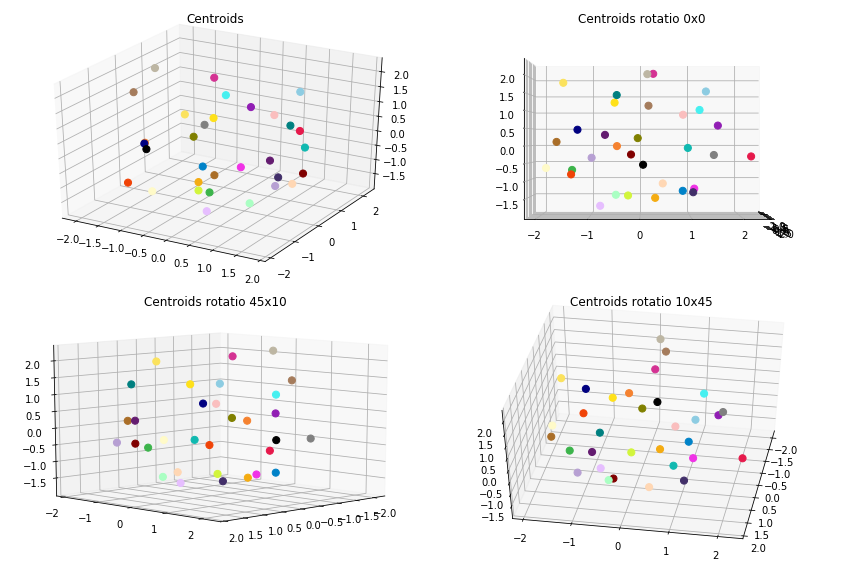

In [15]:
mds = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    random_state=0,
    n_jobs=-1
)
X_cnt = mds.fit_transform(centroids)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Centroids")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Centroids rotatio 0x0")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(0, 0)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Centroids rotatio 45x10")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("Centroids rotatio 10x45")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(45, 10)
plt.tight_layout()
plt.show()

#### Clusterização dos dados de Teste

Por fim, realizada a clusterização dos dados de teste e a apresentação das 8 primeiras frases do conjunto de teste juntamente com outras duas frases do cluster ao qual foi identificado como o melhor.

In [16]:
Xtest = X_test.to_numpy()
for i, xt in enumerate(XT[:8]):
    clt = kclusterer.classify(xt)
    print("*", Xtest[i])
    for frase in utils.shuffle(df[df["cluster"] == clt].to_numpy())[:2]:
        print("  - ", frase[0])
    print("-" * 20)

* Se eu ativar roaming agora, já posso utilizar?
  -  Como desligar meus dados automaticamente quando o WI-FI está disponível?
  -  Estou recebendo chamadas indesejadas de números desconhecidos, como posso ativar Não perturbe?
--------------------
* Fui assaltado, preciso acionar seguro.
  -  Eu tenho um cartão SIM no meu aparelho e eu gostaria de desbloqueá-lo.
  -  Eu não sei como desbloquear o meu novo dispositivo. Pode me dizer como?
--------------------
* Estou bastante cansado do meu telefone existente e gostaria de saber quando eu vou ser elegível para sua atualização?
  -  É possível trocar meu celular?
  -  Como fazer a troca de um aparelho com vocês?
--------------------
* Oi, como posso ativar o encaminhamento de chamada no meu plano?
  -  Como desligar meus dados automaticamente quando o WI-FI está disponível?
  -  Estou recebendo chamadas indesejadas de números desconhecidos, como posso ativar Não perturbe?
--------------------
* Eu não consigo acessar meu email
  -  Não c

#### Métricas

Abaixo são apresentadas métricas para demonstrar o quanto a clusterização parece funcionar.

In [17]:
hom = homogeneity_score(y_test, [kclusterer.classify(xt) for xt in XT])
compl = completeness_score(y_test, [kclusterer.classify(xt) for xt in XT])
silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

print("Homogeneidade    : ", np.round(hom, 3))
print("Completude       : ", np.round(compl, 3))
print("Silhouette       : ", np.round(silh, 3))

Homogeneidade    :  0.703
Completude       :  0.713
Silhouette       :  -0.018


Como exemplo de comparação, foi executado o mesmo algoritmo de clusterização (conforme apresentado acima) entretanto variando a quantidade do número de clusters para verificar como as métricas se comportam.

In [18]:
def multi_kmeans(X, XT, k):
    kclusterer_ = KMeansClusterer(k, distance=cosine_distance, repeats=30, avoid_empty_clusters=True)
    assigned_clusters = kclusterer_.cluster(X, assign_clusters=True)
    hom = homogeneity_score(y_test, [kclusterer_.classify(xt) for xt in XT])
    compl = completeness_score(y_test, [kclusterer_.classify(xt) for xt in XT])
    silh = silhouette_score(XT, labels=[kclusterer_.classify(xt) for xt in XT], metric="cosine", random_state=0)
    dbs = davies_bouldin_score(1-cosine_similarity(XT), labels=[kclusterer.classify(xt) for xt in XT])
    return {"K": k, "HOM": hom, "COMPL": compl, "SILH": silh}

clusterizacao = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    results = list(exc.map(partial(multi_kmeans, X, XT), range(kmin, kmax), chunksize=10))
    for r in results:   
        clusterizacao.append({
            "Qtd. Cluster": r["K"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "Silhouette": np.round(r["SILH"], 3)
        })

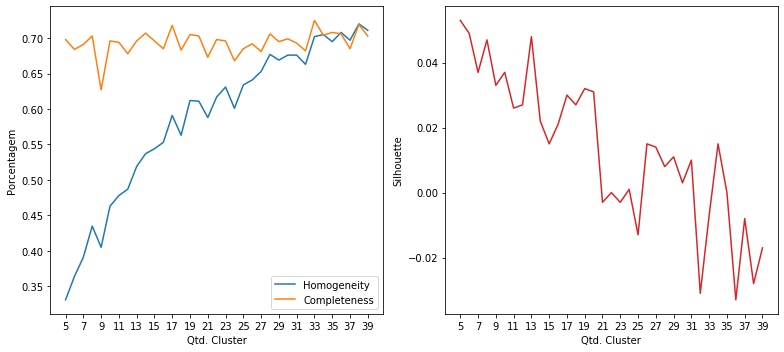

In [19]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Qtd. Cluster", "Homogeneity", "Completeness", "Silhouette"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Homogeneity"], label="Homogeneity")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Completeness"], label="Completeness")
plt.xticks(range(kmin, kmax, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(kmin, kmax, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

#### Escolha da quantidade de Cluster

Como não sabe-se ao certo quantos clusteres na realidade podem vir a existir, considerou-se que a quantidade máxima de clusters seria algo em torno de 40.

Para calcular exatamente qual a quantidade máxima, utilizou-se do maior valor dados pelas métricas Elbow e Silhouette (cada uma dando seu valor ideal de clusteres).

Abaixo segue o resultado.

In [20]:
def calculate_silhouette_metric(X, K):
    km_ = KMeansClusterer(
        K, distance=cosine_distance,
        repeats=10,
        avoid_empty_clusters=True
    )
    assigned_clusters_ = np.array(km_.cluster(X, assign_clusters=True)).ravel()
    centroids = km_.means()
    sh_score = silhouette_score(X, assigned_clusters_, metric='cosine', random_state=0)
    return [len(centroids), sh_score]

print("Running Elbow...")
elbow_error = []
elbow_amount_clusters = 2
elbow_cosine_distance = np.copy(1 - cosine_similarity(X))
for _ in range(5):
    elbow_instance = elbow(elbow_cosine_distance, kmin, kmax + 1)
    elbow_instance.process()
    amc = elbow_instance.get_amount()
    if amc > elbow_amount_clusters:
        elbow_amount_clusters = amc
        elbow_error = elbow_instance.get_wce()

print("Running Silhouette...")

scores = []
silhouette_amount_clusters = 0
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    silhouette = np.asarray(list(exc.map(partial(calculate_silhouette_metric, X), range(kmin, kmax + 1), chunksize=5)))
    amount, silhouette_scores = silhouette[:, 0], silhouette[:, 1]
    silhouette_scores[np.isnan(silhouette_scores)] = -1
    silhouette_amount_clusters = int(amount[np.where(silhouette_scores == np.max(silhouette_scores))][0])

print("N. Elbow      Cluster : ", elbow_amount_clusters)
print("N. Silhouette Cluster : ", silhouette_amount_clusters)
qtd_cluster = elbow_amount_clusters if elbow_amount_clusters > silhouette_amount_clusters else silhouette_amount_clusters

Running Elbow...
Running Silhouette...
N. Elbow      Cluster :  21
N. Silhouette Cluster :  34


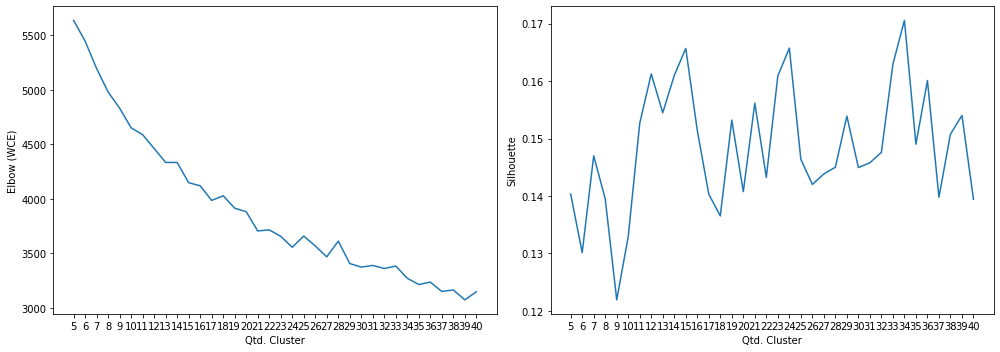

In [21]:
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(range(len(elbow_error)), elbow_error)
plt.xticks(range(len(elbow_error)), range(kmin, kmax + 1, 1))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Elbow (WCE)")

ax = plt.subplot(1, 2, 2)
plt.plot(range(len(silhouette_scores)), silhouette_scores)
plt.xticks(range(len(silhouette_scores)), range(kmin, kmax + 1, 1))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

In [22]:
kclusterer = KMeansClusterer(
    qtd_cluster,
    distance=cosine_distance,
    repeats=30,
    rng=0,
    avoid_empty_clusters=True
)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [23]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(qtd_cluster):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(qtd_cluster)], np.asarray(info)[:, 1]])

print("Frases por cluster:")
data = []
for i in range(qtd_cluster):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=3).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))


print("-" * 20)
print("Documentos por cluster:")
HTML(df_inf.to_html(index=False, header=False))

Frases por cluster:


title,cluster
Há certas partes na minha cidade onde eu não tenho sinal. Pode me dizer qual poderia ser o motivo?,0
Eu não recebo sinal quando estou no Edifício 32.,0
Estou planejando uma viagem ao Havaí e estava pensando se eu vou ter sinal lá.,0
"Quero mudar os provedores de serviço, ainda posso manter meu mesmo número de telefone?",1
"Oi, a velocidade de dados no meu dispositivo ainda está muito abaixo dos níveis anunciados. Isso já está acontecendo por dois meses agora. Como serei compensado por isso? Estou pensando em mudar de novo. Isto é uma quebra de contrato.",1
Eu preciso de ajuda para manter o meu número antigo enquanto mudo de fornecedores.,1
Por que a sinal da operadora em São Paulo está tão ruim?,2
Quero que meu aparelho pare de buscar sinal quando chego em um novo país,2
"Eu já tenho um sim da operadora, eu quero adicionar serviço de roaming internacional.",2
Qual plano de dados é o menos caro para mim?,3


--------------------
Documentos por cluster:


C0,15
C1,16
C2,3
C3,13
C4,11
C5,17
C6,20
C7,15
C8,5
C9,35
C10,32


---

### **TF-IDF**

No caso do tf-idf, assim como no doc2vec foi escolhido um máximo de até 500 features (ou dimensões). Entretanto, diferentemente do doc2vec o tf-idf não adiciona dimensões caso a quantidade de termos (palavras) seja inferior a esse máximo, mas ele corta caso for maior.

In [24]:
P = X_train.shape[0]
print("Tokenization...")
documents_tfidf = [" ".join(tokenizer(doc)) for doc in X_train]
print("Qtd documentos treino: ", len(documents_tfidf))
print("Qtd Intents treino   : ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos treino:  552
Qtd Intents treino   :  32
Finished...


In [25]:
documents_tfidf[:10]

['ir viajar certar empresar fornecer cobertura telefonar viagem poder informacaes servico recepcao disponivel',
 'servico bot oferecer',
 'voce um nome',
 'nao recarregar desativar ativar',
 'voce poder ajudar mudar tocar telefonar',
 'configurar email thunderbird',
 'nao precisar mais',
 'nao conseguir acessar web telefonar nao precisar configuracao',
 'poder correar voz permanentemente remover planar',
 'tutorial configuracao redar fiar android']

In [26]:
tfidf = TfidfVectorizer(max_features=1500)
X_trans = tfidf.fit_transform(documents_tfidf)

Validação do modelo gerado pelo TF-IDF... teste tanto nos dados apresentados para treinamento quanto nos dados de testes e as acurácias alcançadas.

Randomicamente escolhendo 100 amostras de teste.

In [27]:
T = 100

dc = np.c_[X_train, y_train]
docs = utils.shuffle([doc for doc in dc], n_samples=T)
docs = [" ".join(tokenizer(doc)) for doc, y in docs]
sim = np.round(1 - cosine_similarity(tfidf.transform(docs)), 3)
acc = []
for i, xt in enumerate(dc[:T]):
    acc.append(int(xt[1]) == int(dc[np.where(sim[i] <= 0.3)][0][1]))
print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))
print("-" * 20)


def validate(X_trans, y_train, tfidf, doc):
    doct = tfidf.transform([doc[0]])
    sim = np.round(1 - cosine_similarity(doct, X_trans), 3).ravel()
    dcs = np.where(sim <= 0.3)
    it = 0.35
    while len(dcs[0]) == 0:
        dcs = np.where(sim <= it)
        it += 0.05
    return int(doc[1]) == int(y_train[dcs[0][0]])

accc = []
dc = np.c_[X_test, y_test]
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    for p in range(5):
        docs1 = utils.shuffle([doc for doc in dc], n_samples=T)
        docs = np.array([[" ".join(tokenizer(doc)), y] for doc, y in docs1])
        acc = list(exc.map(partial(validate, X_trans, y_train, tfidf), docs))
        print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
        accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 99.0
--------------------
 - Acurácia teste 1  : 60.0
 - Acurácia teste 2  : 61.0
 - Acurácia teste 3  : 63.0
 - Acurácia teste 4  : 61.0
 - Acurácia teste 5  : 61.0
- Acurácia média teste: 61.2


#### Clusterização

Utilizou-se o KMeans definindo a quantidade de clusters para o número ideal de categorias existentes no caso 33. A métrica de distância utilizada, não foi a euclidiana, mas sim a de cosseno (métrica comumente usada na classificação de texto em seu espaço vetorial).

In [30]:
X = np.array(tfidf.transform(documents_tfidf).todense())
XT = np.array(tfidf.transform([" ".join(tokenizer(doc)) for doc in X_test]).todense())

In [31]:
kclusterer = KMeansClusterer(
    clusters,
    distance=cosine_distance,
    repeats=30,
    rng=0,
    avoid_empty_clusters=True
)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

KeyboardInterrupt: 

In [ ]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(clusters):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(clusters)], np.asarray(info)[:, 1]])

print("Frases por cluster:")
data = []
for i in range(clusters):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=2).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))

print("-" * 20)
print("Documentos por cluster:")
HTML(df_inf.to_html(index=False, header=False))

#### Visualização

Apresentação dos protótipos gerados pelo KMeans, reduzindo a dimensão usando o algoritmo MDS (Multidimensional Scaling).

In [ ]:
mds = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    random_state=0,
    n_jobs=-1
)
X_cnt = mds.fit_transform(centroids)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Centroids")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Centroids rotatio 0x0")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(0, 0)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Centroids rotatio 45x10")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("Centroids rotatio 10x45")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(45, 10)
plt.tight_layout()
plt.show()

#### Clusterização dos dados de Teste

Por fim, realizada a clusterização dos dados de teste e a apresentação das 8 primeiras frases do conjunto de teste juntamente com outras duas frases do cluster ao qual foi identificado como o melhor.

In [ ]:
Xtest = X_test.to_numpy()
for i, xt in enumerate(XT[:8]):
    clt = kclusterer.classify(xt)
    print("*", Xtest[i])
    for frase in utils.shuffle(df[df["cluster"] == clt].to_numpy())[:2]:
        print("  - ", frase[0])
    print("-" * 20)

#### Métricas

Abaixo são apresentadas métricas para demonstrar o quanto a clusterização parece funcionar.

In [ ]:
hom = homogeneity_score(y_test, [kclusterer.classify(xt) for xt in XT])
compl = completeness_score(y_test, [kclusterer.classify(xt) for xt in XT])
silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

print("Homogeneidade: ", np.round(hom, 3))
print("Completude   : ", np.round(compl, 3))
print("Silhouette   : ", np.round(silh, 3))

In [ ]:
def multi_kmeans(X, XT, k):
    kclusterer_ = KMeansClusterer(k, distance=cosine_distance, repeats=30, avoid_empty_clusters=True)
    assigned_clusters = kclusterer_.cluster(X, assign_clusters=True)
    hom = homogeneity_score(y_test, [kclusterer_.classify(xt) for xt in XT])
    compl = completeness_score(y_test, [kclusterer_.classify(xt) for xt in XT])
    silh = silhouette_score(XT, labels=[kclusterer_.classify(xt) for xt in XT], metric="cosine", random_state=0)
    return {"K": k, "HOM": hom, "COMPL": compl, "SILH": silh}

clusterizacao = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    results = list(exc.map(partial(multi_kmeans, X, XT), range(kmin, kmax), chunksize=10))
    for r in results:   
        clusterizacao.append({
            "Qtd. Cluster": r["K"],
            "Homogeneity": np.round(r["HOM"], 3),
            "Completeness": np.round(r["COMPL"], 3),
            "Silhouette": np.round(r["SILH"], 3),
        })

In [ ]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Qtd. Cluster", "Homogeneity", "Completeness", "Silhouette"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Homogeneity"], label="Homogeneity")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Completeness"], label="Completeness")
plt.xticks(range(kmin, kmax, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(kmin, kmax, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

#### Escolha da quantidade de Cluster

Como não sabe-se ao certo quantos clusteres na realidade podem vir a existir, considerou-se que a quantidade máxima de clusters seria algo em torno de 10% da quantidade de dados existentes.

Para calcular exatamente qual a quantidade máxima, utilizou-se do maior valor dados pelas métricas Elbow e Silhouette (cada uma dando seu valor ideal de clusteres).

Abaixo segue o resultado.

In [ ]:
def calculate_silhouette_metric(X, K):
    km_ = KMeansClusterer(
        K, distance=cosine_distance,
        repeats=10,
        avoid_empty_clusters=True
    )
    assigned_clusters_ = np.array(km_.cluster(X, assign_clusters=True)).ravel()
    centroids = km_.means()
    sh_score = silhouette_score(X, assigned_clusters_, metric='cosine', random_state=0)
    return [len(centroids), sh_score]

print("Running Elbow...")
elbow_error = []
elbow_amount_clusters = 2
elbow_cosine_distance = np.copy(1 - cosine_similarity(X))
for _ in range(5):
    elbow_instance = elbow(elbow_cosine_distance, kmin, kmax + 1)
    elbow_instance.process()
    amc = elbow_instance.get_amount()
    if amc > elbow_amount_clusters:
        elbow_amount_clusters = amc
        elbow_error = elbow_instance.get_wce()

print("Running Silhouette...")

scores = []
silhouette_amount_clusters = 0
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    silhouette = np.asarray(list(exc.map(partial(calculate_silhouette_metric, X), range(kmin, kmax + 1), chunksize=5)))
    amount, silhouette_scores = silhouette[:, 0], silhouette[:, 1]
    silhouette_scores[np.isnan(silhouette_scores)] = -1
    silhouette_amount_clusters = int(amount[np.where(silhouette_scores == np.max(silhouette_scores))][0])

print("N. Elbow      Cluster : ", elbow_amount_clusters)
print("N. Silhouette Cluster : ", silhouette_amount_clusters)
qtd_cluster = elbow_amount_clusters if elbow_amount_clusters > silhouette_amount_clusters else silhouette_amount_clusters

In [ ]:
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(range(len(elbow_error)), elbow_error)
plt.xticks(range(len(elbow_error)), range(kmin, kmax + 1, 1))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Elbow (WCE)")

ax = plt.subplot(1, 2, 2)
plt.plot(range(len(silhouette_scores)), silhouette_scores)
plt.xticks(range(len(silhouette_scores)), range(kmin, kmax + 1, 1))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

In [ ]:
kclusterer = KMeansClusterer(
    qtd_cluster,
    distance=cosine_distance,
    repeats=30,
    rng=0,
    avoid_empty_clusters=True
)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [ ]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(qtd_cluster):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.c_[[f"C{i}" for i in range(qtd_cluster)], np.asarray(info)[:, 1]])

print("Frases por cluster:")
data = []
for i in range(qtd_cluster):
    T = df.to_numpy()
    data += utils.shuffle(T[T[:, 1] == i], n_samples=2).tolist()
df = pd.DataFrame(data, columns=["title", "cluster"])
display(HTML(df.sort_values(by=["cluster"]).to_html(index=False)))


print("-" * 20)
print("Documentos por cluster:")
HTML(df_inf.to_html(index=False, header=False))